<a href="https://colab.research.google.com/github/JakubCzech/PyTorch_AutoEncoder/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [13]:
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain),len(xtest)))

169009152/169001437 [==============================] - 2s 0us/step
No of training datapoints:50000
No of Test datapoints:10000


In [16]:
def add_noise(img,noise_type="gaussian"):
  
  row,col=28,28
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    mean=0
    var=10
    sigma=var**.5
    noise=np.random.normal(-5.9,5.9,img.shape)
    noise=noise.reshape(row,col)
    img=img+noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col)
    noise=noise.reshape(row,col)
    img=img+img*noise
    return img
  

In [17]:
noises=["gaussian","speckle"]
noise_ct=0
noise_id=0
traindata=np.zeros((60000,28,28))



for idx in tqdm(range(len(xtrain))):
  
  if noise_ct<(len(xtrain)/2):
    noise_ct+=1
    traindata[idx]=add_noise(xtrain[idx],noise_type=noises[noise_id])
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id])) 




noise_ct=0
noise_id=0
testdata=np.zeros((10000,28,28))

for idx in tqdm(range(len(xtest))):
  
  if noise_ct<(len(xtest)/2):
    noise_ct+=1
    x=add_noise(xtest[idx],noise_type=noises[noise_id])
    testdata[idx]=x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id]))

  0%|          | 0/50000 [00:00<?, ?it/s]


ValueError: ignored

Text(0.5, 1.0, 'Noised Image')

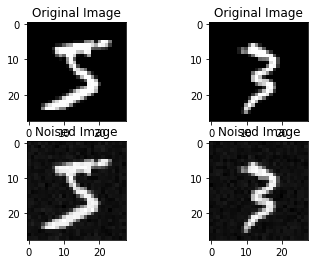

In [ ]:
f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0],cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0],cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[25000],cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[25000],cmap="gray")
axes[1,1].set_title("Noised Image")

In [ ]:
class noisedDataset(Dataset):
  
  def __init__(self,datasetnoised,datasetclean,labels,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.labels=labels
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    y=self.labels[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)
      
    
    return (xNoise,xClean,y)

In [ ]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata,xtrain,ytrain,tsfms)
testset=noisedDataset(testdata,xtest,ytest,tsfms)

In [ ]:
batch_size=32



trainloader=DataLoader(trainset,batch_size=32,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)

In [ ]:
class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x

In [10]:
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

  
model=denoising_model().to(device)
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)


epochs=120
l=len(trainloader)
losslist=list()
epochloss=0
running_loss=0
for epoch in range(epochs):
  
  print("Entering Epoch: ",epoch)
  for dirty,clean,label in tqdm((trainloader)):
    
    
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)
    
    
    
    #-----------------Forward Pass----------------------
    output=model(dirty)
    loss=criterion(output,clean)
    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    epochloss+=loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss=0
  print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))

  0%|          | 1/1875 [00:00<04:01,  7.75it/s]

Entering Epoch:  0


  2%|▏         | 36/1875 [00:00<00:05, 356.50it/s]

======> epoch: 0/120, Loss:0.07390813529491425
Entering Epoch:  1


  2%|▏         | 29/1875 [00:00<00:06, 289.31it/s]

======> epoch: 1/120, Loss:0.06754414737224579
Entering Epoch:  2


  2%|▏         | 36/1875 [00:00<00:05, 357.12it/s]

======> epoch: 2/120, Loss:0.061743490397930145
Entering Epoch:  3


  1%|▏         | 28/1875 [00:00<00:06, 274.71it/s]

======> epoch: 3/120, Loss:0.06944812089204788
Entering Epoch:  4


  2%|▏         | 34/1875 [00:00<00:05, 330.55it/s]

======> epoch: 4/120, Loss:0.05823671072721481
Entering Epoch:  5


  2%|▏         | 36/1875 [00:00<00:05, 354.15it/s]

======> epoch: 5/120, Loss:0.05419972538948059
Entering Epoch:  6


  2%|▏         | 34/1875 [00:00<00:05, 338.73it/s]

======> epoch: 6/120, Loss:0.05722615122795105
Entering Epoch:  7


  2%|▏         | 36/1875 [00:00<00:05, 359.30it/s]

======> epoch: 7/120, Loss:0.053994737565517426
Entering Epoch:  8


  2%|▏         | 36/1875 [00:00<00:05, 358.89it/s]

======> epoch: 8/120, Loss:0.04745198041200638
Entering Epoch:  9


  2%|▏         | 37/1875 [00:00<00:05, 364.99it/s]

======> epoch: 9/120, Loss:0.041546501219272614
Entering Epoch:  10


  2%|▏         | 33/1875 [00:00<00:05, 328.85it/s]

======> epoch: 10/120, Loss:0.04691106453537941
Entering Epoch:  11


  2%|▏         | 37/1875 [00:00<00:05, 362.03it/s]

======> epoch: 11/120, Loss:0.04571568965911865
Entering Epoch:  12


  2%|▏         | 35/1875 [00:00<00:05, 349.07it/s]

======> epoch: 12/120, Loss:0.04468531534075737
Entering Epoch:  13


  1%|▏         | 26/1875 [00:00<00:07, 257.74it/s]

======> epoch: 13/120, Loss:0.039937954396009445
Entering Epoch:  14


  2%|▏         | 36/1875 [00:00<00:05, 353.86it/s]

======> epoch: 14/120, Loss:0.04037726670503616
Entering Epoch:  15


  2%|▏         | 37/1875 [00:00<00:05, 362.07it/s]

======> epoch: 15/120, Loss:0.0382247269153595
Entering Epoch:  16


  2%|▏         | 35/1875 [00:00<00:05, 347.68it/s]

======> epoch: 16/120, Loss:0.04232996329665184
Entering Epoch:  17


  1%|▏         | 27/1875 [00:00<00:06, 267.47it/s]

======> epoch: 17/120, Loss:0.04393631964921951
Entering Epoch:  18


  2%|▏         | 36/1875 [00:00<00:05, 359.67it/s]

======> epoch: 18/120, Loss:0.037614502012729645
Entering Epoch:  19


  2%|▏         | 37/1875 [00:00<00:05, 362.99it/s]

======> epoch: 19/120, Loss:0.041628915816545486
Entering Epoch:  20


  2%|▏         | 36/1875 [00:00<00:05, 349.12it/s]

======> epoch: 20/120, Loss:0.03770923987030983
Entering Epoch:  21


  2%|▏         | 34/1875 [00:00<00:05, 335.44it/s]

======> epoch: 21/120, Loss:0.03970419242978096
Entering Epoch:  22


  2%|▏         | 34/1875 [00:00<00:05, 338.12it/s]

======> epoch: 22/120, Loss:0.03529002144932747
Entering Epoch:  23


  2%|▏         | 36/1875 [00:00<00:05, 356.95it/s]

======> epoch: 23/120, Loss:0.03709547594189644
Entering Epoch:  24


  2%|▏         | 36/1875 [00:00<00:05, 354.05it/s]

======> epoch: 24/120, Loss:0.03319254145026207
Entering Epoch:  25


  1%|▏         | 25/1875 [00:00<00:07, 243.93it/s]

======> epoch: 25/120, Loss:0.03489907085895538
Entering Epoch:  26


  2%|▏         | 36/1875 [00:00<00:05, 358.27it/s]

======> epoch: 26/120, Loss:0.040639955550432205
Entering Epoch:  27


  2%|▏         | 35/1875 [00:00<00:05, 341.79it/s]

======> epoch: 27/120, Loss:0.03533746302127838
Entering Epoch:  28


  2%|▏         | 36/1875 [00:00<00:05, 351.49it/s]

======> epoch: 28/120, Loss:0.030985651537775993
Entering Epoch:  29


  2%|▏         | 36/1875 [00:00<00:05, 357.84it/s]

======> epoch: 29/120, Loss:0.0349787212908268
Entering Epoch:  30


  2%|▏         | 36/1875 [00:00<00:05, 351.94it/s]

======> epoch: 30/120, Loss:0.03227173537015915
Entering Epoch:  31


  2%|▏         | 37/1875 [00:00<00:05, 364.77it/s]

======> epoch: 31/120, Loss:0.03669975325465202
Entering Epoch:  32


  2%|▏         | 35/1875 [00:00<00:05, 346.05it/s]

======> epoch: 32/120, Loss:0.0335710346698761
Entering Epoch:  33


  2%|▏         | 37/1875 [00:00<00:05, 363.87it/s]

======> epoch: 33/120, Loss:0.030276509001851082
Entering Epoch:  34


  2%|▏         | 36/1875 [00:00<00:05, 354.89it/s]

======> epoch: 34/120, Loss:0.03181052580475807
Entering Epoch:  35


  2%|▏         | 37/1875 [00:00<00:05, 361.59it/s]

======> epoch: 35/120, Loss:0.029536910355091095
Entering Epoch:  36


  2%|▏         | 37/1875 [00:00<00:05, 364.95it/s]

======> epoch: 36/120, Loss:0.029347384348511696
Entering Epoch:  37


  2%|▏         | 35/1875 [00:00<00:05, 347.55it/s]

======> epoch: 37/120, Loss:0.03263954445719719
Entering Epoch:  38


  2%|▏         | 32/1875 [00:00<00:05, 311.97it/s]

======> epoch: 38/120, Loss:0.028006913140416145
Entering Epoch:  39


  2%|▏         | 36/1875 [00:00<00:05, 353.26it/s]

======> epoch: 39/120, Loss:0.02829766646027565
Entering Epoch:  40


  2%|▏         | 31/1875 [00:00<00:05, 309.13it/s]

======> epoch: 40/120, Loss:0.028504135087132454
Entering Epoch:  41


  1%|▏         | 27/1875 [00:00<00:06, 264.81it/s]

======> epoch: 41/120, Loss:0.02899296209216118
Entering Epoch:  42


  2%|▏         | 37/1875 [00:00<00:05, 363.04it/s]

======> epoch: 42/120, Loss:0.03022293746471405
Entering Epoch:  43


  1%|▏         | 26/1875 [00:00<00:07, 256.61it/s]

======> epoch: 43/120, Loss:0.03284802660346031
Entering Epoch:  44


  2%|▏         | 36/1875 [00:00<00:05, 358.67it/s]

======> epoch: 44/120, Loss:0.0272512286901474
Entering Epoch:  45


  2%|▏         | 37/1875 [00:00<00:05, 364.11it/s]

======> epoch: 45/120, Loss:0.02894889935851097
Entering Epoch:  46


  2%|▏         | 37/1875 [00:00<00:05, 366.13it/s]

======> epoch: 46/120, Loss:0.028696777299046516
Entering Epoch:  47


  2%|▏         | 30/1875 [00:00<00:06, 292.42it/s]

======> epoch: 47/120, Loss:0.03164760395884514
Entering Epoch:  48


  2%|▏         | 37/1875 [00:00<00:05, 362.75it/s]

======> epoch: 48/120, Loss:0.026582583785057068
Entering Epoch:  49


  2%|▏         | 37/1875 [00:00<00:05, 367.30it/s]

======> epoch: 49/120, Loss:0.029810667037963867
Entering Epoch:  50


  1%|▏         | 27/1875 [00:00<00:07, 261.71it/s]

======> epoch: 50/120, Loss:0.02746501751244068
Entering Epoch:  51


  1%|▏         | 28/1875 [00:00<00:06, 274.59it/s]

======> epoch: 51/120, Loss:0.027684008702635765
Entering Epoch:  52


  2%|▏         | 32/1875 [00:00<00:05, 317.48it/s]

======> epoch: 52/120, Loss:0.025401918217539787
Entering Epoch:  53


  2%|▏         | 37/1875 [00:00<00:05, 358.75it/s]

======> epoch: 53/120, Loss:0.02605774812400341
Entering Epoch:  54


  2%|▏         | 35/1875 [00:00<00:05, 345.04it/s]

======> epoch: 54/120, Loss:0.029562674462795258
Entering Epoch:  55


  1%|▏         | 28/1875 [00:00<00:06, 273.06it/s]

======> epoch: 55/120, Loss:0.027285253629088402
Entering Epoch:  56


  1%|▏         | 27/1875 [00:00<00:06, 269.89it/s]

======> epoch: 56/120, Loss:0.02567913569509983
Entering Epoch:  57


  1%|▏         | 28/1875 [00:00<00:06, 278.78it/s]

======> epoch: 57/120, Loss:0.024462701752781868
Entering Epoch:  58


  2%|▏         | 36/1875 [00:00<00:05, 357.86it/s]

======> epoch: 58/120, Loss:0.029282748699188232
Entering Epoch:  59


  2%|▏         | 34/1875 [00:00<00:05, 338.28it/s]

======> epoch: 59/120, Loss:0.024491777643561363
Entering Epoch:  60


  2%|▏         | 35/1875 [00:00<00:05, 346.02it/s]

======> epoch: 60/120, Loss:0.027185896411538124
Entering Epoch:  61


  1%|▏         | 27/1875 [00:00<00:06, 264.32it/s]

======> epoch: 61/120, Loss:0.024787655100226402
Entering Epoch:  62


  2%|▏         | 34/1875 [00:00<00:05, 334.93it/s]

======> epoch: 62/120, Loss:0.026560569182038307
Entering Epoch:  63


  2%|▏         | 29/1875 [00:00<00:06, 284.15it/s]

======> epoch: 63/120, Loss:0.02646181546151638
Entering Epoch:  64


  2%|▏         | 36/1875 [00:00<00:05, 350.38it/s]

======> epoch: 64/120, Loss:0.025200601667165756
Entering Epoch:  65


  2%|▏         | 36/1875 [00:00<00:05, 358.89it/s]

======> epoch: 65/120, Loss:0.025139261037111282
Entering Epoch:  66


  2%|▏         | 36/1875 [00:00<00:05, 357.66it/s]

======> epoch: 66/120, Loss:0.026964303106069565
Entering Epoch:  67


  2%|▏         | 31/1875 [00:00<00:06, 301.14it/s]

======> epoch: 67/120, Loss:0.02240719087421894
Entering Epoch:  68


  1%|▏         | 27/1875 [00:00<00:07, 263.93it/s]

======> epoch: 68/120, Loss:0.030164413154125214
Entering Epoch:  69


  2%|▏         | 35/1875 [00:00<00:05, 345.16it/s]

======> epoch: 69/120, Loss:0.025788888335227966
Entering Epoch:  70


  2%|▏         | 36/1875 [00:00<00:05, 351.60it/s]

======> epoch: 70/120, Loss:0.0256733987480402
Entering Epoch:  71


  1%|▏         | 27/1875 [00:00<00:07, 263.23it/s]

======> epoch: 71/120, Loss:0.028872579336166382
Entering Epoch:  72


  2%|▏         | 33/1875 [00:00<00:05, 327.69it/s]

======> epoch: 72/120, Loss:0.02261229418218136
Entering Epoch:  73


  2%|▏         | 33/1875 [00:00<00:05, 328.73it/s]

======> epoch: 73/120, Loss:0.024544382467865944
Entering Epoch:  74


  1%|▏         | 28/1875 [00:00<00:06, 272.12it/s]

======> epoch: 74/120, Loss:0.02334005944430828
Entering Epoch:  75


  1%|▏         | 28/1875 [00:00<00:06, 277.97it/s]

======> epoch: 75/120, Loss:0.02827257476747036
Entering Epoch:  76


  2%|▏         | 34/1875 [00:00<00:05, 338.31it/s]

======> epoch: 76/120, Loss:0.023902181535959244
Entering Epoch:  77


  1%|▏         | 27/1875 [00:00<00:07, 258.53it/s]

======> epoch: 77/120, Loss:0.024606650695204735
Entering Epoch:  78


  1%|▏         | 27/1875 [00:00<00:06, 269.89it/s]

======> epoch: 78/120, Loss:0.02232174389064312
Entering Epoch:  79


  2%|▏         | 34/1875 [00:00<00:05, 338.54it/s]

======> epoch: 79/120, Loss:0.025496643036603928
Entering Epoch:  80


  2%|▏         | 37/1875 [00:00<00:05, 363.75it/s]

======> epoch: 80/120, Loss:0.02586689032614231
Entering Epoch:  81


  2%|▏         | 34/1875 [00:00<00:05, 338.58it/s]

======> epoch: 81/120, Loss:0.024019408971071243
Entering Epoch:  82


  1%|▏         | 27/1875 [00:00<00:06, 268.20it/s]

======> epoch: 82/120, Loss:0.025079449638724327
Entering Epoch:  83


  2%|▏         | 37/1875 [00:00<00:05, 361.47it/s]

======> epoch: 83/120, Loss:0.02533227950334549
Entering Epoch:  84


  1%|▏         | 26/1875 [00:00<00:07, 255.60it/s]

======> epoch: 84/120, Loss:0.0228948462754488
Entering Epoch:  85


  2%|▏         | 36/1875 [00:00<00:05, 350.27it/s]

======> epoch: 85/120, Loss:0.029081646353006363
Entering Epoch:  86


  2%|▏         | 36/1875 [00:00<00:05, 351.65it/s]

======> epoch: 86/120, Loss:0.025683533400297165
Entering Epoch:  87


  2%|▏         | 37/1875 [00:00<00:05, 365.56it/s]

======> epoch: 87/120, Loss:0.027088895440101624
Entering Epoch:  88


  2%|▏         | 36/1875 [00:00<00:05, 358.49it/s]

======> epoch: 88/120, Loss:0.025203624740242958
Entering Epoch:  89


  1%|▏         | 28/1875 [00:00<00:06, 273.32it/s]

======> epoch: 89/120, Loss:0.0259280763566494
Entering Epoch:  90


  2%|▏         | 37/1875 [00:00<00:05, 363.17it/s]

======> epoch: 90/120, Loss:0.0260948296636343
Entering Epoch:  91


  2%|▏         | 33/1875 [00:00<00:05, 324.95it/s]

======> epoch: 91/120, Loss:0.023835988715291023
Entering Epoch:  92


  2%|▏         | 29/1875 [00:00<00:06, 283.03it/s]

======> epoch: 92/120, Loss:0.024441849440336227
Entering Epoch:  93


  2%|▏         | 35/1875 [00:00<00:05, 348.38it/s]

======> epoch: 93/120, Loss:0.021829672157764435
Entering Epoch:  94


  1%|▏         | 26/1875 [00:00<00:07, 254.80it/s]

======> epoch: 94/120, Loss:0.024807026609778404
Entering Epoch:  95


  2%|▏         | 35/1875 [00:00<00:05, 343.28it/s]

======> epoch: 95/120, Loss:0.023963864892721176
Entering Epoch:  96


  2%|▏         | 35/1875 [00:00<00:05, 345.18it/s]

======> epoch: 96/120, Loss:0.020975759252905846
Entering Epoch:  97


  2%|▏         | 32/1875 [00:00<00:05, 314.23it/s]

======> epoch: 97/120, Loss:0.023734629154205322
Entering Epoch:  98


  2%|▏         | 34/1875 [00:00<00:05, 336.51it/s]

======> epoch: 98/120, Loss:0.023058487102389336
Entering Epoch:  99


  1%|▏         | 25/1875 [00:00<00:07, 248.59it/s]

======> epoch: 99/120, Loss:0.02314283326268196
Entering Epoch:  100


  2%|▏         | 35/1875 [00:00<00:05, 346.02it/s]

======> epoch: 100/120, Loss:0.025776298716664314
Entering Epoch:  101


  1%|▏         | 28/1875 [00:00<00:06, 271.05it/s]

======> epoch: 101/120, Loss:0.02170603536069393
Entering Epoch:  102


  1%|▏         | 26/1875 [00:00<00:07, 259.34it/s]

======> epoch: 102/120, Loss:0.02224644273519516
Entering Epoch:  103


  2%|▏         | 34/1875 [00:00<00:05, 330.14it/s]

======> epoch: 103/120, Loss:0.02155289053916931
Entering Epoch:  104


  1%|▏         | 28/1875 [00:00<00:06, 275.17it/s]

======> epoch: 104/120, Loss:0.023309677839279175
Entering Epoch:  105


  2%|▏         | 35/1875 [00:00<00:05, 343.17it/s]

======> epoch: 105/120, Loss:0.022444218397140503
Entering Epoch:  106


  2%|▏         | 37/1875 [00:00<00:05, 364.41it/s]

======> epoch: 106/120, Loss:0.019233720377087593
Entering Epoch:  107


  2%|▏         | 37/1875 [00:00<00:05, 366.52it/s]

======> epoch: 107/120, Loss:0.022710483521223068
Entering Epoch:  108


  1%|▏         | 28/1875 [00:00<00:06, 277.05it/s]

======> epoch: 108/120, Loss:0.020239297300577164
Entering Epoch:  109


  2%|▏         | 37/1875 [00:00<00:05, 360.79it/s]

======> epoch: 109/120, Loss:0.02317073382437229
Entering Epoch:  110


  2%|▏         | 33/1875 [00:00<00:05, 324.54it/s]

======> epoch: 110/120, Loss:0.026418412104249
Entering Epoch:  111


  2%|▏         | 36/1875 [00:00<00:05, 357.17it/s]

======> epoch: 111/120, Loss:0.021989958360791206
Entering Epoch:  112


  2%|▏         | 35/1875 [00:00<00:05, 345.25it/s]

======> epoch: 112/120, Loss:0.02410968206822872
Entering Epoch:  113


  1%|▏         | 27/1875 [00:00<00:06, 265.63it/s]

======> epoch: 113/120, Loss:0.022107182070612907
Entering Epoch:  114


  1%|▏         | 26/1875 [00:00<00:07, 254.60it/s]

======> epoch: 114/120, Loss:0.02031022310256958
Entering Epoch:  115


  1%|▏         | 27/1875 [00:00<00:06, 266.60it/s]

======> epoch: 115/120, Loss:0.02559761144220829
Entering Epoch:  116


  2%|▏         | 37/1875 [00:00<00:05, 365.00it/s]

======> epoch: 116/120, Loss:0.02082092873752117
Entering Epoch:  117


  2%|▏         | 30/1875 [00:00<00:06, 290.04it/s]

======> epoch: 117/120, Loss:0.021292634308338165
Entering Epoch:  118


  1%|▏         | 28/1875 [00:00<00:06, 277.27it/s]

======> epoch: 118/120, Loss:0.02101954072713852
Entering Epoch:  119


100%|██████████| 1875/1875 [00:05<00:00, 329.42it/s]

======> epoch: 119/120, Loss:0.023454952985048294


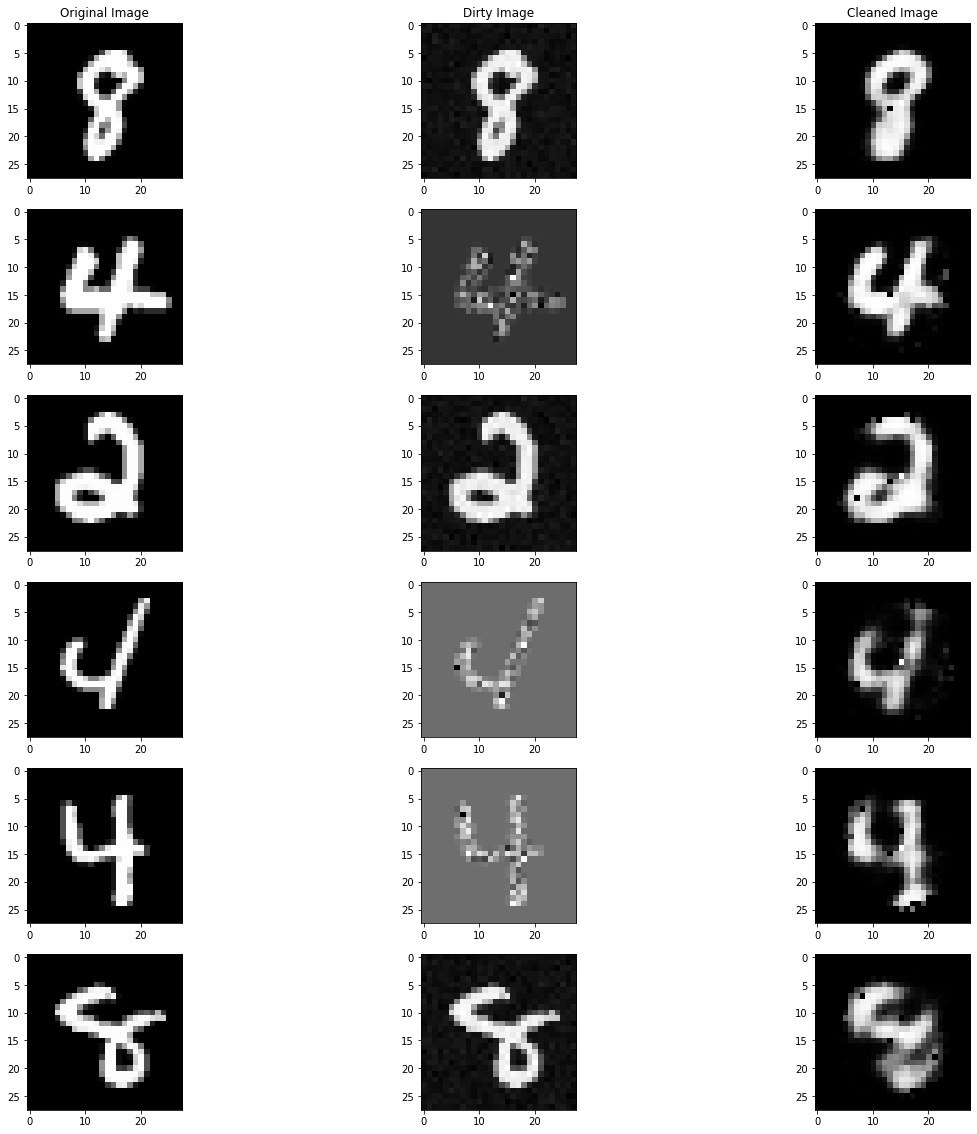

In [11]:
f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")